In [16]:
# Importar bibliotecas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, Input
from keras.models import Model
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Desactivar advertencias
warnings.filterwarnings("ignore")


In [4]:
# Descargar el conjunto de datos
path = kagglehub.dataset_download("jangedoo/utkface-new")
print("Path to dataset files:", path)

# Asumiendo que las imágenes están en una subcarpeta 'UTKFace' dentro del path descargado
BASE_DIR = os.path.join(path, 'UTKFace')

# Verifica que la ruta exista
if not os.path.exists(BASE_DIR):
    print(f"Error: La ruta {BASE_DIR} no existe.")
else:
    print(f"Ruta {BASE_DIR} encontrada. Procediendo a cargar imágenes.")

# Cargar las rutas de las imágenes y las etiquetas de género
imagenes = []
generos = []

# Procesa los archivos de imagen
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    gender = int(temp[1])
    imagenes.append(image_path)
    generos.append(gender)


100%|██████████| 331M/331M [00:02<00:00, 151MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1
Ruta /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace encontrada. Procediendo a cargar imágenes.


  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# Función para extraer características de las imágenes
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=(64, 64))  # Reducción de tamaño
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 64, 64, 1)  # 1 representa un canal de gris
    return features

# Extraer características
X = extract_features(imagenes)
y_gender = np.array(generos)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
# Definir la arquitectura del modelo
input_shape = (64, 64, 1)
inputs = Input(input_shape)
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_pool1)
max_pool2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_pool2)
max_pool3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

flatten = Flatten()(max_pool3)
dense1 = Dense(256, activation='relu')(flatten)
dropout_1 = Dropout(0.3)(dense1)

output_1 = Dense(1, activation='sigmoid', name='genero')(dropout_1)

model = Model(inputs=[inputs], outputs=[output_1])

# Compilar el modelo
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics={"genero": "accuracy"}
)


In [7]:
# Entrenar el modelo
history = model.fit(X, y_gender, batch_size=32, epochs=10, validation_split=0.2)


Epoch 1/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 171s 284ms/step - accuracy: 0.7318 - loss: 1.2815 - val_accuracy: 0.8355 - val_loss: 0.3628
Epoch 2/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 180s 247ms/step - accuracy: 0.8422 - loss: 0.3596 - val_accuracy: 0.8549 - val_loss: 0.3162
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 154s 260ms/step - accuracy: 0.8619 - loss: 0.3178 - val_accuracy: 0.8600 - val_loss: 0.3199
Epoch 4/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 190s 241ms/step - accuracy: 0.8714 - loss: 0.2984 - val_accuracy: 0.8671 - val_loss: 0.3048
Epoch 5/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 205s 246ms/step - accuracy: 0.8910 - loss: 0.2631 - val_accuracy: 0.8726 - val_loss: 0.2922
Epoch 6/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 199s 241ms/step - accuracy: 0.8889 - loss: 0.2588 - val_accuracy: 0.8777 - val_loss: 0.2920
Epoch 7/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 199s 235ms/step - accuracy: 0.9014 - loss: 0.2436 - val_accuracy: 0.8798 - val_loss: 0.2850
Epoch 8/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 142s 239ms/step - accuracy: 0.9064 -

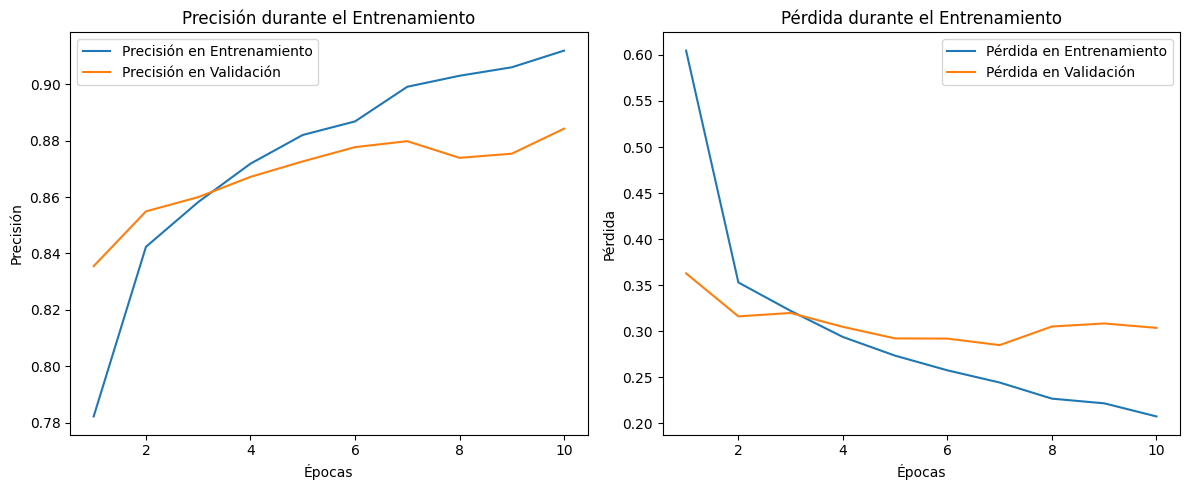

In [9]:
# Graficar precisión y pérdida
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(epochs, history.history['val_accuracy'], label='Precisión en Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(epochs, history.history['val_loss'], label='Pérdida en Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# Hacer predicciones en el conjunto de datos
y_pred = model.predict(X)
predicted_gender = (y_pred > 0.5).astype(int).flatten()  # Convertir probabilidades a predicciones binarias

# Calcular el F1-score
f1 = f1_score(y_gender, predicted_gender)
print(f"F1 Score para la clasificación de género: {f1:.2f}")


741/741 ━━━━━━━━━━━━━━━━━━━━ 51s 68ms/step
F1 Score para la clasificación de género: 0.92


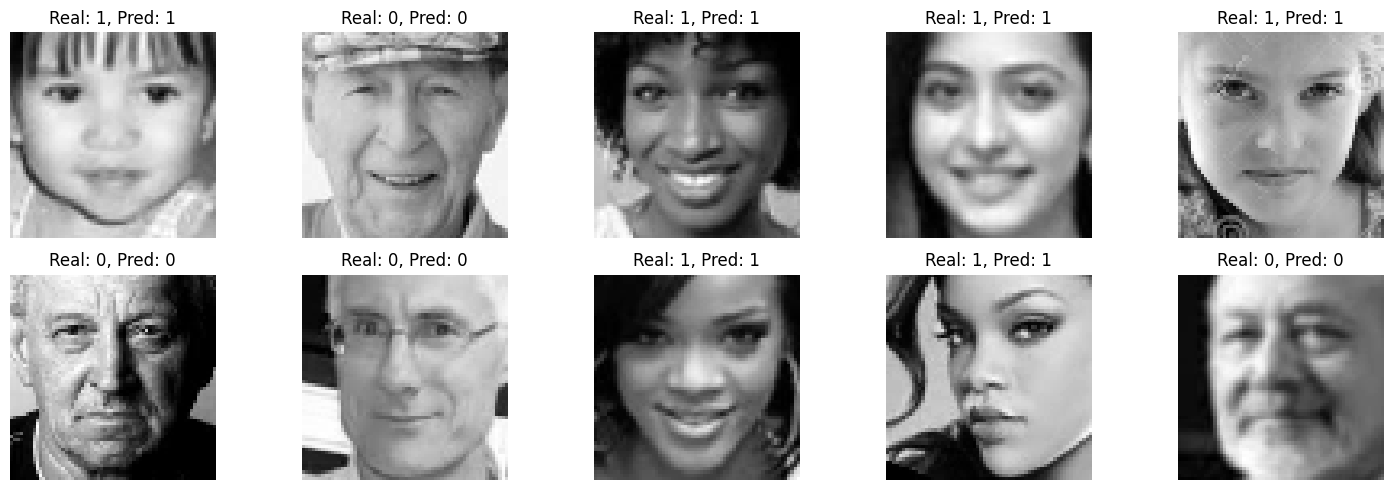

In [14]:
# Evaluar 10 imágenes
sample_indices = np.random.choice(range(len(X)), 10, replace=False)
sample_images = X[sample_indices]
sample_true_labels = y_gender[sample_indices]
sample_predictions = predicted_gender[sample_indices]

# Mostrar resultados
plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].reshape(64, 64), cmap='gray')
    plt.title(f"Real: {sample_true_labels[i]}, Pred: {sample_predictions[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
